##  K - means en utilisant time warping

In [5]:
from scipy.spatial import distance
import numpy as np
import math
import matplotlib as plt
import matplotlib.pyplot as plt

#mesure de similarité dtw entre deux séries temporelles. x = un pixel sur un intervalle de temps
def dtw(x, x_prime):
  R=np.zeros((len(x),len(x_prime)))
  for i in range(len(x)):
    for j in range(len(x_prime)):
      R[i, j] = distance.euclidean(x[i], x_prime[j]) ** 2
      if i > 0 or j > 0:
        R[i, j] += min(
          R[i-1, j  ] if i > 0             else math.inf,
          R[i  , j-1] if j > 0             else math.inf,
          R[i-1, j-1] if (i > 0 and j > 0) else math.inf
        )

  return R[-1, -1] ** (1/2)

In [6]:
def dtw_matrice(x,centroides):
    distances = np.zeros((len(x), len(centroides)))
    index_i = 0
    index_j = 0     
    for i in x:
        for j in centroides:
            distances[index_i,index_j] = dtw(i.reshape(-1,1),j.reshape(-1,1))
            index_j += 1
        index_i +=1
        index_j = 0
    return distances

In [7]:
#génération des matrices : 
data=np.random.rand(5,1)
sequence1 = np.random.rand(5,1)
sequence2 = np.random.rand(5,1)
sequence3 = np.random.rand(5,1)
sequence4= np.random.rand(5,1)

print(dtw(sequence1,sequence2))
print(sequence1)

0.6126168924771616
[[0.19509875]
 [0.98911318]
 [0.23513281]
 [0.52745596]
 [0.06648308]]


In [8]:
# Regrouper les séquences dans une liste
#data = [sequence1, sequence2, sequence3, sequence4]
data = [[2,10,5,4,3,2], [7,11,5,3,1,7], [1,10,5,0,1,2], [10,9,8,7,6,1]]
data=np.array(data)
print(data)

(4, 6)
[[ 2 10  5  4  3  2]
 [ 7 11  5  3  1  7]
 [ 1 10  5  0  1  2]
 [10  9  8  7  6  1]]


In [9]:
#Importing required modules
 
import numpy as np
from scipy.spatial.distance import cdist 
 
#Function to implement steps given in previous section
def kmeans(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
    
    #finding the distance between centroids and all the data points
    distances = dtw_matrice(x, centroids) #Step 2
    
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points

In [10]:
label = kmeans(data,3,100)

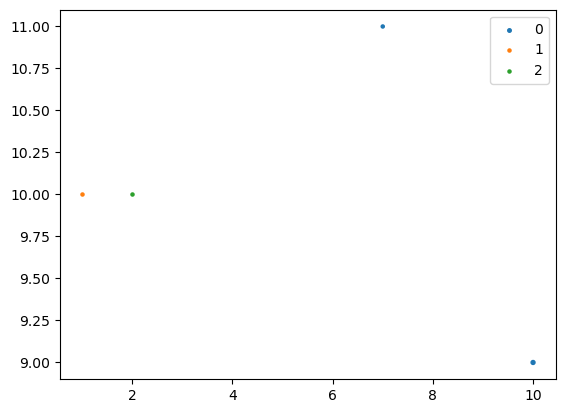

In [11]:
#Visualize the results
u_labels = np.unique(label)
for i in u_labels:
    plt.scatter(data[label == i , 0] , data[label == i , 1], data[label == i, 2] , label = i)
plt.legend()
plt.show()

# Trying the algo over some selected pixels

### Creation of the data_set

In [12]:
from selection_pixels_dtw import *
import os
import cv2
from PIL import Image
import rasterio as rio

In [13]:
# List of target pixels
pixels_de_interet = pix_danone + pix_agri + pix_ensta + pix_apt + pix_lac + pix_foret
len(pixels_de_interet)

54

In [14]:
# dir = "../../ressources/images"
# images_list = os.listdir(dir)
# with rio.open(dir+'/crop_SENTINEL2A_20151226-111142-750_L2A_T31UDQ_D_V1-1.tif', 'r') as ds:
#     band3 = ds.read(3)
# print(band3.shape)
# lista = list()
# for pixel in pixels_de_interet:
#     lista.append(band3[pixel[0], pixel[1]])
# print(len(lista))

In [15]:
dir = "../../ressources/images"
images_list = os.listdir(dir)
line = 0
matrice = np.zeros((len(pixels_de_interet), len(images_list)))
for image in images_list:
    with rio.open(dir+'/'+image, 'r') as ds:
        # arr = ds.read()
        # band1 = raster.read(1)
        # band2 = raster.read(2)
        band3 = ds.read(3)
        # band4 = raster.read(4)
    # Extraction of target pixels
    for pixel,j in zip(pixels_de_interet, range(len(pixels_de_interet)-1)):
        pass
        matrice[j,line] = band3[pixel[0], pixel[1]]
    line +=1     
        

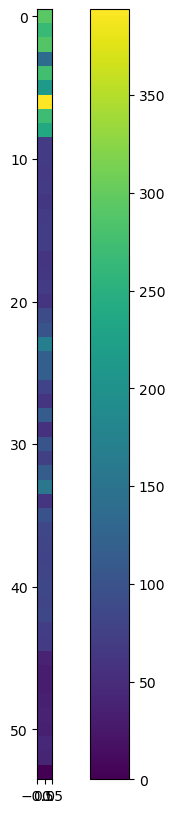

In [16]:
#Looking for a pixel
img = (matrice/8).astype(int)
#grayImage = cv2.cvtColor(uint_img, cv2.COLOR_GRAY2BGR)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.colorbar()
plt.show()


In [17]:
yhat = kmeans(matrice,6,200)

In [18]:
len(pix_ensta)

9

In [19]:
print(len(yhat))
yhat

54


array([3, 3, 3, 5, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 5, 5, 5, 2, 1, 5, 1, 2, 1, 5, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 4, 4, 4, 4, 4, 4, 4, 4, 0])

## A simple function to show the obtained results

In [20]:
import collections
def affichage(yhat,pix_interet):
    name = ''
    dico = collections.Counter(yhat)
    for key in list(dico.keys()):
        dico[key] = [f'number of vectors = {dico[key]}'] 
        for index,pos in zip(yhat,range(len(yhat))):
            if index == key:
                if 0<=pos<=8: name = 'pix_danone'
                elif 9<=pos<=17: name = 'pix_agri'
                elif 18<=pos<=26: name = 'pix_ensta'
                elif 27<=pos<=35: name = 'pix_apt'
                elif 36<=pos<=44: name = 'pix_lac'
                elif 45<=pos<=53: name = 'pix_apt'

                dico[key].append(f'{pix_interet[pos]}:{name}')

    for key in dico:
        print(f'cluster numero {key}:\n-------------------------------')
        for part in dico[key]:
            print(f'{part}')
        print('-------------------------------')



In [21]:
affichage(yhat,pixels_de_interet)

cluster numero 3:
-------------------------------
number of vectors = 8
[383, 497]:pix_danone
[383, 500]:pix_danone
[387, 501]:pix_danone
[387, 505]:pix_danone
[384, 508]:pix_danone
[388, 509]:pix_danone
[384, 504]:pix_danone
[386, 504]:pix_danone
-------------------------------
cluster numero 5:
-------------------------------
number of vectors = 7
[383, 504]:pix_danone
[450, 641]:pix_ensta
[443, 636]:pix_ensta
[439, 629]:pix_ensta
[408, 444]:pix_apt
[405, 455]:pix_apt
[414, 440]:pix_apt
-------------------------------
cluster numero 1:
-------------------------------
number of vectors = 18
[318, 438]:pix_agri
[322, 435]:pix_agri
[324, 433]:pix_agri
[329, 429]:pix_agri
[333, 426]:pix_agri
[337, 424]:pix_agri
[339, 422]:pix_agri
[344, 418]:pix_agri
[350, 414]:pix_agri
[447, 618]:pix_ensta
[454, 627]:pix_ensta
[454, 631]:pix_ensta
[405, 448]:pix_apt
[412, 446]:pix_apt
[407, 465]:pix_apt
[420, 458]:pix_apt
[394, 598]:pix_lac
[388, 532]:pix_lac
-------------------------------
cluster nume